In [15]:
import numpy as np
import scipy

import itertools

import matplotlib.pyplot as plt

In [16]:
rng = np.random.default_rng(seed=0)

# Lattice parameters

In [17]:
Nc = 2
Nd = 4

L = 8
Lt = 16

beta = 2.5

lattice_shape = tuple([L] * (Nd-1) + [Lt])

# Utility functions

In [18]:
def trace(M):
    # Trace over the last dimension (by default np.trace traces over the first
    # two dimensions)
    return np.trace(M, axis1=-1, axis2=-2)

def adjoint(M):
    return np.conj(np.swapaxes(M, axis1=-1, axis2=-2))

def random_suN_element(scale, batch_shape):
    """
    Generates a random SU(N) element by sampling a gaussian Lie-algebra-valued
    field and exponentiating. Returns an array with shape (*batch_shape, Nc, Nc).

    The value of 'scale' determines how close the output will be to the identity
    -- if scale is small, then the output will be closer to the identity.

    Note that the output distribution is somewhat unclear, but this does not
    affect any of the uses of this function below.
    """
    shape = (*batch_shape, Nc, Nc)
    X = (rng.standard_normal(shape) + 1j * rng.standard_normal(shape)) / np.sqrt(2)
    # Project X to be Hermitian
    X = 0.5 * (X + adjoint(X))
    # Project X to be traceless
    # Note: broadcasting is very useful here (see https://numpy.org/doc/stable/user/basics.broadcasting.html)
    X = X - 1/Nc * trace(X)[...,None,None] * np.eye(Nc, Nc)
    # Now X is an element of the Lie algebra, so expm(X) will be in SU(N)
    return scipy.linalg.expm(1j * scale * X)

def apply_gauge_transformation(U, g):
    """
    Takes a gauge field U and a gauge transformation g, and outputs the gauge
    transformed field defined by

        U'_\mu(x) = g(x) U_\mu(x) g^\dag(x + \hat{mu})

    Exercise: complete this function.
    """
    U_g = []
    for mu in range(Nd):
        U_g_mu = g @ U[mu] @ np.roll(adjoint(g), -1, mu)
        U_g.append(U_g_mu)
    return np.stack(U_g, axis=0)


# Project onto U(N) using Gram-Schmidt
def project_uN(g):
    Nc = g.shape[-1]

    for i in range(Nc):
        v_i = g[..., i, :]
        for j in range(i):
            v_j = g[..., j, :]
            dot = np.sum(np.conj(v_j) * v_i, axis=-1)
            v_i = v_i - dot[..., None] * v_j
        v_i = v_i / np.linalg.norm(v_i, axis=-1)[..., None]

        g[..., i, :] = v_i

    return g

def project_suN(g):
    g = project_uN(g)
    return g * np.conj(np.linalg.det(g)**(1/Nc))[...,None,None]

In [19]:
def wilson_action(U, *, beta):
    result = 0
    for mu in range(Nd):
        for nu in range(mu):
            P_mu_nu = U[mu] @ np.roll(U[nu], -1, mu) @ np.roll(adjoint(U[mu]), -1, nu) @ adjoint(U[nu])
            result = result + np.sum(trace(P_mu_nu.real))
    return -beta / Nc * result

def plaquette(U):
    volume = np.prod(lattice_shape)
    num_plaq = volume * Nd * (Nd - 1) // 2
    return -wilson_action(U, beta=1) / num_plaq

def compute_staple(U, mu):
    result = 0
    for nu in range(Nd):
        if nu == mu:
            continue
        staple_left = np.roll(U[nu], -1, mu) @ np.roll(adjoint(U[mu]), -1, nu) @ adjoint(U[nu])
        staple_right = np.roll(adjoint(U[nu]), (-1, 1), (mu, nu)) @ np.roll(adjoint(U[mu]), 1, nu) @ np.roll(U[nu], 1, nu)

        result = result + staple_left + staple_right
    return result

# SU(2) Heatbath

This section implements a SU(2) heatbath algorithm, primarily following Gattringer and Lang, Section 4.3.1. In comparison to the metropolis implementation in the previous notebook, this runs slightly slower, but thermalizes an order of magnitude faster.

There are no exercises in this section, but if you want to explore this further here are some possibilities:

- Add overrelaxation (see Gattringer and Lang, Section 4.3.2)

- Genrealize to $SU(N)$ for $N \geq 3$. This is discussed in Gatteringer and Lang Section 4.3.1, but the discussion there is somewhat lacking. In particular, the sentence "It is no group element of SU(2) but proportional to 1" should probably read "It is no group element of SU(2), but it can be replaced with a group element without changing the conditional probability". The key lemma needed is that for any $2 \times 2$ complex matrix $W$, there exists a projection $\mathcal{P}(W) \in SU(2)$ such that $\mathrm{Re} \mathrm{Tr} (U W) = \mathrm{Re} \mathrm{Tr} (U \mathcal{P}(W))$. For a concrete implementation, see here: https://github.com/lehner/gpt/blob/master/lib/gpt/algorithms/markov/su2_heat_bath.py

In [20]:
# Generates x_0 \sim sqrt(1 - x_0^2) exp(2 a x_0)
# Originally from https://inspirehep.net/literature/220728, though
# I've used Gattringer and Lang as a reference
def _sample_x0(a):
    accepted = np.zeros(a.shape, dtype=bool)
    x0 = np.zeros_like(a)
    while np.sum(accepted) < np.sum(np.ones_like(a)):
        def _uniform(maxval=1.0):
            return rng.uniform(low=0.0, high=maxval, size=a.shape)

        r = _uniform()
        r1 = 1.0 - _uniform()
        r2 = _uniform(maxval=2*np.pi)
        r3 = 1.0 - _uniform()

        lam_sq = -1 / (4 * a) * (np.log(r1) + np.cos(r2)**2 * np.log(r3))

        newly_accepted = r**2 < 1 - lam_sq
        to_update = np.logical_and(newly_accepted, np.logical_not(accepted))

        x0 = np.where(to_update, 1 - 2 * lam_sq, x0)

        accepted = np.logical_or(accepted, newly_accepted)

    return x0

def _su2_heatbath_dist(a):
    x0 = _sample_x0(a)

    r = rng.normal(size=(3, *a.shape))
    x = r / np.linalg.norm(r, axis=0) * np.sqrt(1 - x0**2)

    X = np.zeros((*a.shape, 2, 2), dtype=np.complex128)
    # x0 + i x[2] sigma_z                                                                                                                                                   
    X[..., 0, 0] = x0 + 1j * x[2]
    X[..., 1, 1] = x0 - 1j * x[2]

    # i x[0] sigma_x + i x[1] sigma_y                                                                                                                                       
    X[..., 0, 1] = 1j * x[0] + x[1]
    X[..., 1, 0] = 1j * x[0] - x[1]

    return X

def su2_heatbath(U, mu, *, beta, update_mask):
    A = beta / Nc * compute_staple(U, mu)

    a = np.sqrt(np.abs(np.linalg.det(A)))

    X = _su2_heatbath_dist(a)
    U_mu_new = X @ adjoint(A) / a[..., None, None]

    U[mu] = U[mu] * update_mask[...,None,None] + (1 - update_mask[...,None,None]) * U_mu_new

    # Project the result back onto SU(N) -- without this change, the values of
    # U_mu drift slowly away from SU(N) due to roundoff error.
    U = project_suN(U)

    return U

In [21]:
# Create a mask that is 1 on even-parity sites, and 0 on odd-parity sites
def make_even_mask(lattice_shape):
    even_mask = np.zeros(lattice_shape)
    for parities in itertools.product([0, 1], repeat=Nd):
        idx = tuple(slice(parity, None, 2) for parity in parities)
        if sum(parities) % 2 == 0:
            even_mask[idx] = 1
    return even_mask

def heatbath_sweep(U, beta):
    even_mask = make_even_mask(lattice_shape=U.shape[1:-2])

    for mu in range(Nd):
        U = su2_heatbath(U, mu, beta=beta, update_mask=even_mask)
        U = su2_heatbath(U, mu, beta=beta, update_mask=1-even_mask)
    return U

# Computing Wilson Loops

In [22]:
# Computes a (mu, nu) wislon loop of size l_mu x l_nu
def wilson_loop(U, mu, nu, l_mu, l_nu):
    W = np.broadcast_to(np.eye(Nc, Nc), U.shape[1:])
    for x in range(l_mu):
        W = W @ np.roll(U[mu], -x, mu)
    for y in range(l_nu):
        W = W @ np.roll(U[nu], (-l_mu, -y), (mu, nu))
    for x in reversed(range(l_mu)):
        W = W @ np.roll(adjoint(U[mu]), (-x, -l_nu), (mu, nu))
    for y in reversed(range(l_nu)):
        W = W @ np.roll(adjoint(U[nu]), -y, nu)

    return np.mean(trace(W.real))

def test_wilson_loop_gauge_invariance(mu, nu, l_mu, l_nu):
    U = random_suN_element(scale=1.0, batch_shape=(Nd, *lattice_shape))
    g = random_suN_element(scale=1.0, batch_shape=lattice_shape)

    U_transformed = apply_gauge_transformation(U, g)

    W_initial = wilson_loop(U, mu, nu, l_mu, l_nu)
    W_transformed = wilson_loop(U_transformed, mu, nu, l_mu, l_nu)

    assert np.allclose(W_initial, W_transformed)
    print(f"[PASSED test_wilson_loop_gauge_invariance {mu=} {nu=} {l_mu=} {l_nu=}]")

test_wilson_loop_gauge_invariance(0, 1, 1, 1)
test_wilson_loop_gauge_invariance(2, 3, 2, 1)
test_wilson_loop_gauge_invariance(2, 0, 2, 3)

[PASSED test_wilson_loop_gauge_invariance mu=0 nu=1 l_mu=1 l_nu=1]
[PASSED test_wilson_loop_gauge_invariance mu=2 nu=3 l_mu=2 l_nu=1]
[PASSED test_wilson_loop_gauge_invariance mu=2 nu=0 l_mu=2 l_nu=3]


In [23]:
def compute_loops(U):
    t_dir = 3
    Lt_max = 5
    Lx_max = 6
    loops = np.zeros((Lx_max+1, Lt_max+1))
    for Lx in range(1,Lx_max+1):
        for Lt in range(1,Lt_max+1):
            # Note: we're Averaging over different spatial dimensions here
            loops[Lx, Lt] = np.mean([wilson_loop(U, i, t_dir, Lx, Lt) for i in range(Nd-1)])
    return loops


# Generating Ensemble

In [24]:
# Cold start -- U = identity
U = random_suN_element(0.0, batch_shape=(Nd, *lattice_shape))

plaq = []
loops = []
# Thermalize -- throw away first ~20 configurations
for _ in range(20):
    U = heatbath_sweep(U, beta)
for i in range(50):
    U = heatbath_sweep(U, beta)
    if i % 10 == 0 and i > 0:
        print(f"Iter {i} plaquette {np.mean(plaq):.5f}")
    plaq.append(plaquette(U))
    loops.append(compute_loops(U))
plaq = np.array(plaq)
loops = np.stack(loops)

Iter 10 plaquette 0.65321
Iter 20 plaquette 0.65335
Iter 30 plaquette 0.65290
Iter 40 plaquette 0.65330


# Analysing data with bootstrap

## Generating bootstrap samples



In [25]:
Nboot = 50
Nsample = loops.shape[0]

# Variation over bootstrap samples
bootstrap_samples = rng.multinomial(Nsample, np.ones(Nsample) / Nsample, size=(Nboot,))
# loops_boot[i,r,t] contains the 'i'th bootstrap sample for an r x t loop
loops_boot = np.einsum("bi,ij... -> bj...", bootstrap_samples, loops) / Nsample

# Static quark potential

We can compute the static quark potential by computing an effective mass:
$$ V(r, t) = \log \frac{W(r, t)}{W(r, t + 1)} $$
The static quark potential is then
$$ V(r) = \lim_{t \to \infty} V(r, t) $$

**Exercise**: implement the function $V(r, t)$ below. The function should compute $V(r, t)$ on each bootstrap sample independently and then return the mean and standard deviation over bootstrap samples.

In [26]:
def V(r, t):
    # FIXME
    return 0, 0

## Plotting the static potential

Here we plot $V(r, t)$ across $r$ for different values of $t$. For smaller values of $t$, we expect excited state contamination, so the values of $V(r, t)$ to approach $V(r)$ from above.

Also plotted is a line indicating the expected
$$ V(r) \sim \frac{\alpha}{r} + V_0 + \sigma r $$
The values of $\alpha$ and $\sigma$ are taken from https://doi.org/10.1103/PhysRevD.50.3399, while the value of $V_0$ was determined by eye

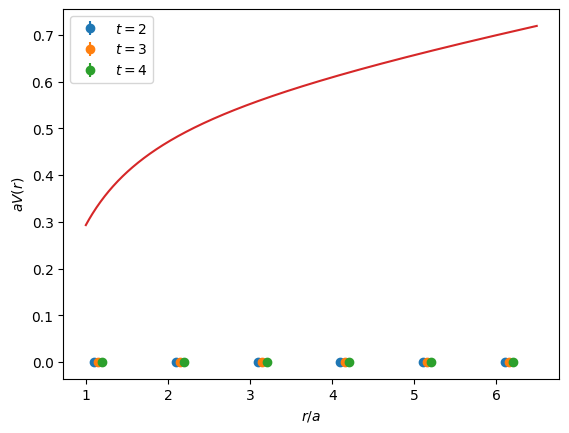

In [27]:
def V_fit(r):
    # The values of alpha and sigma here are taken from
    # https://doi.org/10.1103/PhysRevD.50.3399
    # The value of V0 is was fit by eye to the data
    # (Note: Fig 2 in the reference has incorrectly labelled axes, which is why
    # it looks different from the plot generated here)
    alpha = -0.29
    sigma = 0.033
    V0 = 0.55
    return alpha/r + sigma * r + V0

r = np.arange(1,7)
for t in range(2,5):
    potential = np.array([V(r_i, t) for r_i in r])
    potential_mean = potential[:,0]
    potential_err = potential[:,1]
    # Offset different values of t so the error bars do not overlap
    offset = 0.05 * t
    plt.errorbar(r + offset, potential_mean, yerr=potential_err, fmt='o', label=f"$t={t}$")

r = np.arange(1,6.5,0.01)
plt.plot(r, V_fit(r))

plt.ylabel("$a V(r)$")
plt.xlabel("$r/a$")
plt.legend(loc="best")

# Additional exercises

Here are some additional (longer) exercises that you can take on in your own time:

- Add additional static quark configurations, e.g. placing the quarks diagonally offset from each other. This requires computing some non-planar Wilson loops, and also gives a test of the restoration of rotational symmetry in the continuum limit.

- Perform a fit to determine the values of $\alpha, V_0$, and $\sigma$ from the data (e.g. using `scipy.optimize.curve_fit`). Using the fit values, compute the Sommer scale $r_0$ defined by

$$ \left. r^2 \frac{dV}{dr} \right|_{r=r_0} = 0.4 $$

- Perform the same calculation at different values of $\beta$, and plot the static quark potential for each value of $\beta$. If you also perform scale setting, you should be able to get the curves for different values of $\beta$ to collapse by appropriately rescaling the axes.